In [1]:
# Generative Adversarial Network (GAN) on MNIST Dataset with Fully Connected Layers for (28 x 28) MNIST Images #

In [2]:
# Increasing the Cell Width of Jupyter Notebook

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Importing Libraries

import os
import torch
import shutil
import tarfile
import torchvision
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
%matplotlib inline

In [4]:
# Image Size of MNIST: (1 x 28 x 28) || Batch Size: 128 || Mean & Std Values: 0.5

image_size = 28
batch_size = 128
stats = ((0.5), (0.5))
#stats = ((0.49139965, 0.48215842, 0.44653094), (0.24703243, 0.24348533, 0.2615879))

In [5]:
# Defining the Dataset and Data Loader for GAN

transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)])

train_ds = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 420857910.32it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39368116.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 145591583.44it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5832984.93it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Defining Functions to Plot Images

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 1, 1, 1)
    stds = torch.tensor(stds).reshape(1, 1, 1, 1)
    return images.cpu() * stds + means


def plot_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(int(nmax/8), 8))
    ax.set_xticks([]);
    ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax], *stats), nrow=int(nmax/8)).permute(1, 2, 0))


def plot_batch(dl, nmax=64):
    for images, _ in dl:
        plot_images(images, nmax)
        break

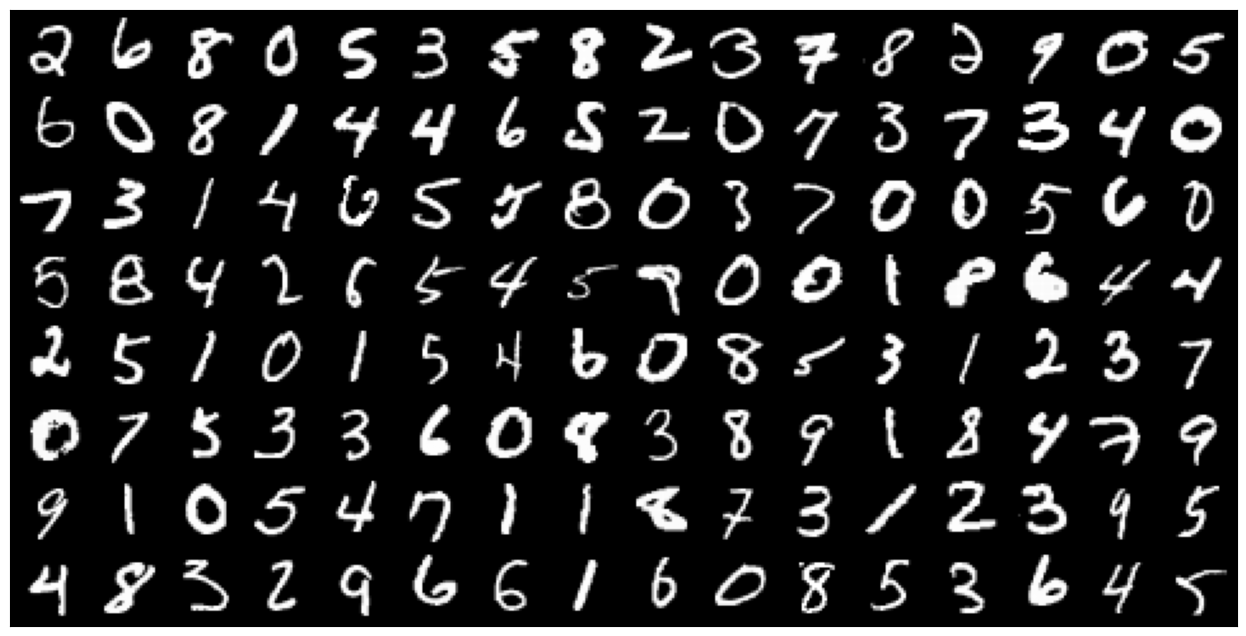

In [7]:
# Plotting 1 Batch of Images from the Data Loader as Grid

plot_batch(train_dl, batch_size)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple, set)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
# Sending the Data Loader to the Current Device

train_dl = DeviceDataLoader(train_dl, device)

In [10]:
in_channels = 1        # CIFAR-10 Dataset Has 3-Channel Images with 32x32 Size
latent_size = 128      # Latent Size of 1x1 Input Samples for the GAN to Generate 32x32 Images

In [11]:
# Definition of the Discriminator Network

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [12]:
# Creating the Discriminator Network to Predict if the Generated Images are Real or Fake

discriminator = to_device(Discriminator(), device)

In [13]:
# Definition of the Generator Network

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [14]:
# Creating the Generator Network to Generate 32x32 New CIFAR Images Which are Checked by the Discriminator Network to Predict If They are Real or Fake

generator = to_device(Generator(latent_size), device)

torch.Size([128, 1, 28, 28])


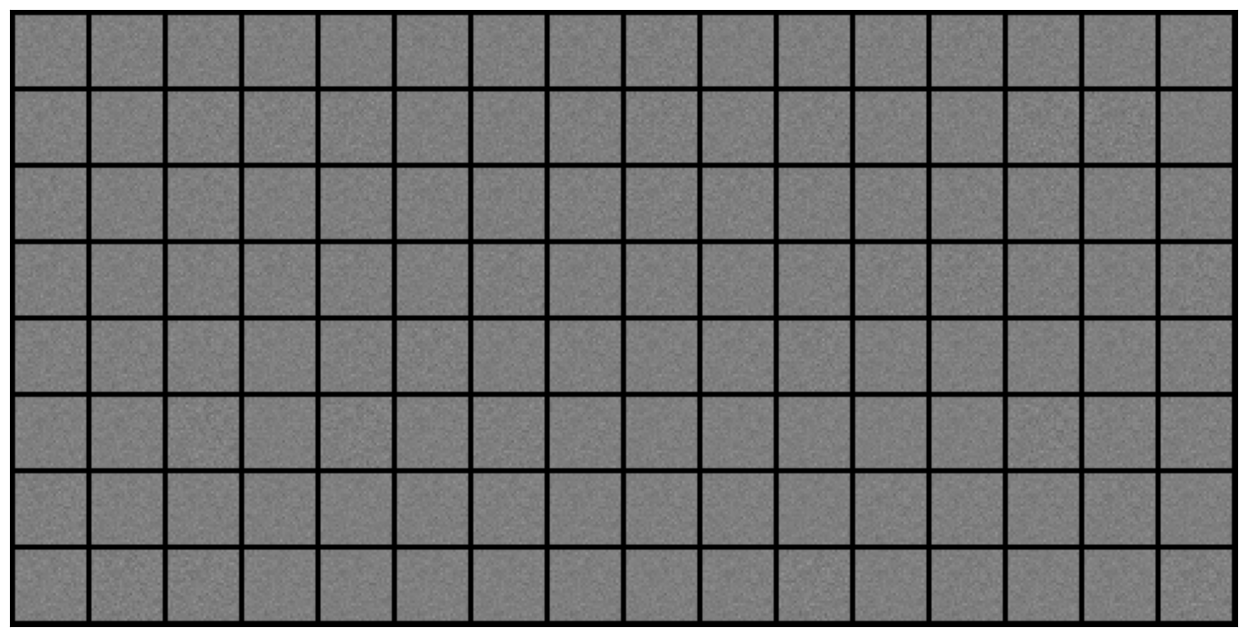

In [15]:
# Plotting a Batch Number of Fake Images Generated from the Input Latent Tensor Before the Training

fixed_latent = torch.randn(batch_size, latent_size, device=device)
fake_images = generator(fixed_latent)
print(fake_images.shape)
plot_images(fake_images, batch_size)

In [16]:
# Trainer Function for the Discriminator

def train_discriminator(real_images, opt_d):
    # Clearing Discriminator Gradients
    opt_d.zero_grad()

    # Passing Real Images Through the Discriminator
    real_preds = discriminator(real_images)                             # Real Predictions from Real Images
    real_targets = torch.ones(real_images.size(0), 1, device=device)    # Real Targets are Represented with 1
    real_loss = F.binary_cross_entropy(real_preds, real_targets)        # Real Loss is Evaluated
    real_score = torch.mean(real_preds).item()                          # Real Score is Evaluated

    # Generating Fake Images
    latent = torch.randn(batch_size, latent_size, device=device)  # Generating Latent Input from Random Torch Values
    fake_images = generator(latent)                                     # Generating Fake Images by the Generator Network

    # Passing Fake Images Through the Discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)   # Fake Targets are Represented with 0
    fake_preds = discriminator(fake_images)                             # Fake Predictions from Fake Images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)        # Fake Loss is Evaluated
    fake_score = torch.mean(fake_preds).item()                          # Fake Score is Evaluated

    # Updating the Discriminator Weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [17]:
# Trainer Function for the Generator

def train_generator(opt_g):
    # Clear Generator Gradients
    opt_g.zero_grad()

    # Generating Fake Images
    latent = torch.randn(batch_size, latent_size, device=device)  # Creating Random Latent Tensor
    fake_images = generator(latent)                                     # Generating Fake Images from the Latent Tensor

    # Trying to Fool the Discriminator
    preds = discriminator(fake_images)                                  # Predictions from Fake Images
    targets = torch.ones(batch_size, 1, device=device)                  # Targets are Represented with 1
    loss = F.binary_cross_entropy(preds, targets)                       # Loss is Evaluated

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [18]:
# Creating a Folder to Store the Sample Images Generated Throughout the Training Process

sample_dir = "./generated"
os.makedirs(sample_dir, exist_ok=True)

In [19]:
# Definition of a Function to Save the Generated Sample Images per Epoch

def save_samples(index, latent_tensors, nmax=64, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images, *stats), os.path.join(sample_dir, fake_fname), nrow=int(nmax/8))
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(int(nmax/8), 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denormalize(fake_images, *stats), nrow=int(nmax/8)).permute(1, 2, 0).clip(0, 1))

Saving generated-images-0000.png


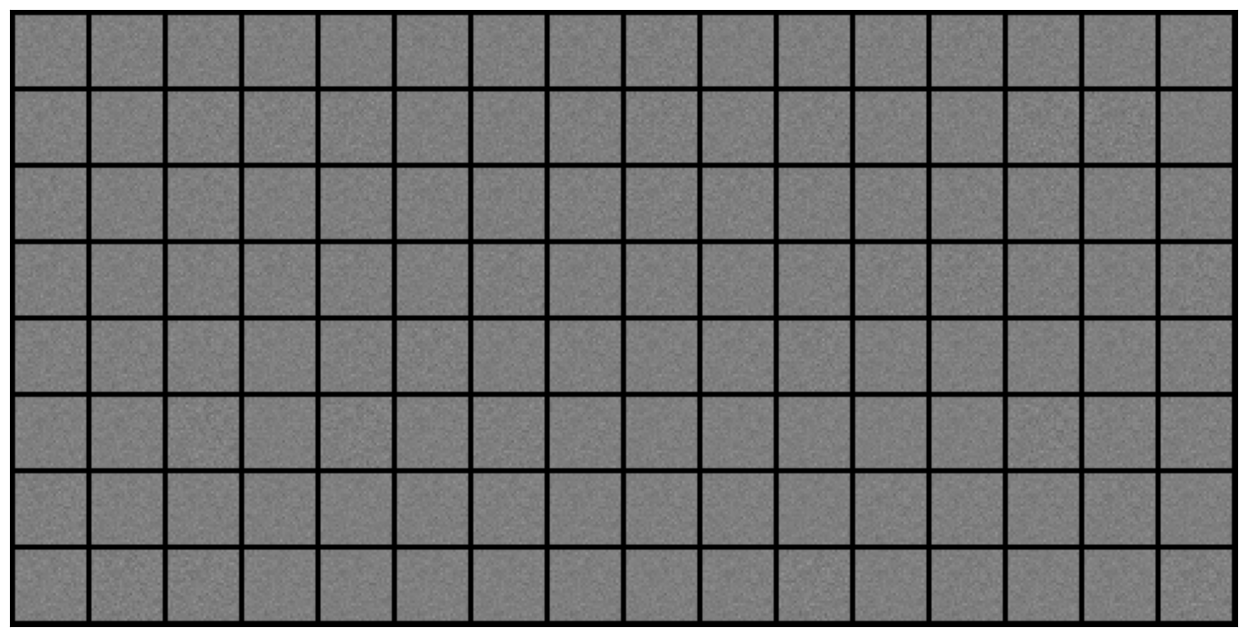

In [20]:
# Saving a Batch Number of Sample Fake Images Generated from the Fixed Latent Tensor

save_samples(0, fixed_latent, fixed_latent.size(0))

In [21]:
# Definition of the fit() Function to Train Generator & Discriminator Networks

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Loss Lists & Score Lists
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Training Discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Training Generator
            loss_g = train_generator(opt_g)

        # Recording Losses & Scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Logging the Losses & Scores (the Last Batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Saving the Generated Images
        save_samples(epoch+start_idx, fixed_latent, fixed_latent.size(0), show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [22]:
lr = 0.0002         # Learning Rate
epochs = 200        # Number of Epochs

In [23]:
# Training Process

history = fit(epochs, lr)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 4.7867, loss_d: 0.4968, real_score: 0.8781, fake_score: 0.2430
Saving generated-images-0001.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 7.0773, loss_d: 0.2273, real_score: 0.9716, fake_score: 0.1535
Saving generated-images-0002.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 6.2903, loss_d: 0.3073, real_score: 0.9940, fake_score: 0.2446
Saving generated-images-0003.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 2.6291, loss_d: 0.4915, real_score: 0.8276, fake_score: 0.1709
Saving generated-images-0004.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 5.0045, loss_d: 0.1316, real_score: 0.9400, fake_score: 0.0148
Saving generated-images-0005.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 4.2033, loss_d: 0.2006, real_score: 0.9474, fake_score: 0.0667
Saving generated-images-0006.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 3.2790, loss_d: 0.2413, real_score: 0.9229, fake_score: 0.0710
Saving generated-images-0007.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 2.1028, loss_d: 0.3189, real_score: 0.8803, fake_score: 0.0432
Saving generated-images-0008.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 2.5368, loss_d: 0.3338, real_score: 0.8875, fake_score: 0.0875
Saving generated-images-0009.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 2.1133, loss_d: 0.4822, real_score: 0.8276, fake_score: 0.0684
Saving generated-images-0010.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 0.8245, loss_d: 0.6284, real_score: 0.7431, fake_score: 0.1460
Saving generated-images-0011.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 2.4351, loss_d: 0.7370, real_score: 0.8469, fake_score: 0.3120
Saving generated-images-0012.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 2.2804, loss_d: 0.7854, real_score: 0.8217, fake_score: 0.3462
Saving generated-images-0013.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 1.4548, loss_d: 0.7523, real_score: 0.7435, fake_score: 0.2878
Saving generated-images-0014.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 1.5633, loss_d: 0.9468, real_score: 0.7320, fake_score: 0.3716
Saving generated-images-0015.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 1.5451, loss_d: 0.8989, real_score: 0.7908, fake_score: 0.3932
Saving generated-images-0016.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 1.0207, loss_d: 0.8612, real_score: 0.6807, fake_score: 0.2876
Saving generated-images-0017.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 1.2645, loss_d: 0.9627, real_score: 0.6845, fake_score: 0.3479
Saving generated-images-0018.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 1.1451, loss_d: 1.0771, real_score: 0.6584, fake_score: 0.3969
Saving generated-images-0019.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 1.2980, loss_d: 0.9837, real_score: 0.6872, fake_score: 0.3680
Saving generated-images-0020.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 1.3788, loss_d: 1.0334, real_score: 0.6835, fake_score: 0.4090
Saving generated-images-0021.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 1.2941, loss_d: 1.1466, real_score: 0.7040, fake_score: 0.4627
Saving generated-images-0022.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 1.0744, loss_d: 1.0228, real_score: 0.6269, fake_score: 0.3536
Saving generated-images-0023.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 1.2068, loss_d: 1.2100, real_score: 0.6241, fake_score: 0.4195
Saving generated-images-0024.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 0.9852, loss_d: 1.1196, real_score: 0.5722, fake_score: 0.3352
Saving generated-images-0025.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 1.0033, loss_d: 1.1487, real_score: 0.5434, fake_score: 0.3319
Saving generated-images-0026.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 1.0499, loss_d: 1.0762, real_score: 0.5948, fake_score: 0.3643
Saving generated-images-0027.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 0.9496, loss_d: 1.1711, real_score: 0.4916, fake_score: 0.2990
Saving generated-images-0028.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 1.2560, loss_d: 1.1601, real_score: 0.5919, fake_score: 0.3891
Saving generated-images-0029.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 0.9677, loss_d: 1.2009, real_score: 0.6033, fake_score: 0.4244
Saving generated-images-0030.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 1.2286, loss_d: 1.2390, real_score: 0.5485, fake_score: 0.3661
Saving generated-images-0031.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 1.0405, loss_d: 1.1210, real_score: 0.6108, fake_score: 0.4071
Saving generated-images-0032.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 1.1458, loss_d: 1.0710, real_score: 0.6119, fake_score: 0.3675
Saving generated-images-0033.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 1.2328, loss_d: 1.1287, real_score: 0.6879, fake_score: 0.4707
Saving generated-images-0034.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 0.9661, loss_d: 1.1786, real_score: 0.5811, fake_score: 0.3924
Saving generated-images-0035.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 1.3679, loss_d: 1.1360, real_score: 0.5877, fake_score: 0.3793
Saving generated-images-0036.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 1.3442, loss_d: 1.2189, real_score: 0.6939, fake_score: 0.4956
Saving generated-images-0037.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 1.0705, loss_d: 1.2363, real_score: 0.5753, fake_score: 0.4130
Saving generated-images-0038.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 1.2205, loss_d: 1.1595, real_score: 0.6845, fake_score: 0.4771
Saving generated-images-0039.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 1.0082, loss_d: 1.2164, real_score: 0.5688, fake_score: 0.4101
Saving generated-images-0040.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 1.0394, loss_d: 1.1871, real_score: 0.5835, fake_score: 0.3932
Saving generated-images-0041.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 0.9516, loss_d: 1.0902, real_score: 0.6195, fake_score: 0.3955
Saving generated-images-0042.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 1.1899, loss_d: 1.1884, real_score: 0.6311, fake_score: 0.4444
Saving generated-images-0043.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 1.1879, loss_d: 1.1703, real_score: 0.6360, fake_score: 0.4484
Saving generated-images-0044.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 1.1139, loss_d: 1.2846, real_score: 0.6500, fake_score: 0.4990
Saving generated-images-0045.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 0.8508, loss_d: 1.2473, real_score: 0.5703, fake_score: 0.4282
Saving generated-images-0046.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 1.1344, loss_d: 1.1387, real_score: 0.6341, fake_score: 0.4187
Saving generated-images-0047.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 1.0407, loss_d: 1.2019, real_score: 0.5944, fake_score: 0.4156
Saving generated-images-0048.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 1.3109, loss_d: 1.2293, real_score: 0.6504, fake_score: 0.4735
Saving generated-images-0049.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 0.9900, loss_d: 1.1800, real_score: 0.5582, fake_score: 0.3734
Saving generated-images-0050.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 0.9989, loss_d: 1.1519, real_score: 0.6181, fake_score: 0.4370
Saving generated-images-0051.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 0.8962, loss_d: 1.2001, real_score: 0.5740, fake_score: 0.4075
Saving generated-images-0052.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 0.8222, loss_d: 1.1228, real_score: 0.6002, fake_score: 0.4017
Saving generated-images-0053.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 0.8482, loss_d: 1.1265, real_score: 0.5509, fake_score: 0.3536
Saving generated-images-0054.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 0.9977, loss_d: 1.1528, real_score: 0.5731, fake_score: 0.3680
Saving generated-images-0055.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 1.0567, loss_d: 1.2567, real_score: 0.5838, fake_score: 0.4425
Saving generated-images-0056.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 0.9593, loss_d: 1.2621, real_score: 0.5466, fake_score: 0.4147
Saving generated-images-0057.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 1.0140, loss_d: 1.1607, real_score: 0.5834, fake_score: 0.4019
Saving generated-images-0058.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 1.0236, loss_d: 1.2904, real_score: 0.5217, fake_score: 0.3804
Saving generated-images-0059.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 1.0561, loss_d: 1.1771, real_score: 0.5805, fake_score: 0.4034
Saving generated-images-0060.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 0.8312, loss_d: 1.3071, real_score: 0.4617, fake_score: 0.3456
Saving generated-images-0061.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 0.8963, loss_d: 1.2728, real_score: 0.5209, fake_score: 0.3936
Saving generated-images-0062.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 0.9642, loss_d: 1.2608, real_score: 0.5535, fake_score: 0.4278
Saving generated-images-0063.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 0.8542, loss_d: 1.1942, real_score: 0.5802, fake_score: 0.4195
Saving generated-images-0064.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 1.0171, loss_d: 1.2655, real_score: 0.6092, fake_score: 0.4725
Saving generated-images-0065.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 0.9347, loss_d: 1.1526, real_score: 0.6001, fake_score: 0.4206
Saving generated-images-0066.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 0.8002, loss_d: 1.2431, real_score: 0.6204, fake_score: 0.4718
Saving generated-images-0067.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 1.0135, loss_d: 1.1874, real_score: 0.6327, fake_score: 0.4534
Saving generated-images-0068.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 0.8822, loss_d: 1.1852, real_score: 0.5875, fake_score: 0.4165
Saving generated-images-0069.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 0.9742, loss_d: 1.1598, real_score: 0.6224, fake_score: 0.4378
Saving generated-images-0070.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 0.9107, loss_d: 1.2484, real_score: 0.5668, fake_score: 0.4274
Saving generated-images-0071.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 0.9374, loss_d: 1.1904, real_score: 0.5388, fake_score: 0.3723
Saving generated-images-0072.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 1.0956, loss_d: 1.2383, real_score: 0.5424, fake_score: 0.4036
Saving generated-images-0073.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 0.9076, loss_d: 1.1187, real_score: 0.5614, fake_score: 0.3626
Saving generated-images-0074.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 0.8973, loss_d: 1.2255, real_score: 0.5707, fake_score: 0.4342
Saving generated-images-0075.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 1.0484, loss_d: 1.1949, real_score: 0.6036, fake_score: 0.4408
Saving generated-images-0076.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 0.7938, loss_d: 1.3222, real_score: 0.4907, fake_score: 0.3721
Saving generated-images-0077.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 0.9177, loss_d: 1.2094, real_score: 0.5629, fake_score: 0.4177
Saving generated-images-0078.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 1.0219, loss_d: 1.2373, real_score: 0.5738, fake_score: 0.4363
Saving generated-images-0079.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 0.9052, loss_d: 1.3167, real_score: 0.5375, fake_score: 0.4366
Saving generated-images-0080.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 0.8872, loss_d: 1.2358, real_score: 0.5341, fake_score: 0.4018
Saving generated-images-0081.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 0.9853, loss_d: 1.1720, real_score: 0.5710, fake_score: 0.4110
Saving generated-images-0082.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 0.9159, loss_d: 1.2694, real_score: 0.6175, fake_score: 0.4849
Saving generated-images-0083.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 0.9347, loss_d: 1.2691, real_score: 0.5910, fake_score: 0.4699
Saving generated-images-0084.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 0.9254, loss_d: 1.2725, real_score: 0.5515, fake_score: 0.4445
Saving generated-images-0085.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 0.9059, loss_d: 1.1642, real_score: 0.5923, fake_score: 0.4232
Saving generated-images-0086.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 0.8049, loss_d: 1.2259, real_score: 0.6055, fake_score: 0.4568
Saving generated-images-0087.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 0.8772, loss_d: 1.3101, real_score: 0.5296, fake_score: 0.4421
Saving generated-images-0088.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 0.9700, loss_d: 1.3596, real_score: 0.5287, fake_score: 0.4592
Saving generated-images-0089.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 0.8946, loss_d: 1.2327, real_score: 0.5615, fake_score: 0.4259
Saving generated-images-0090.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 0.8541, loss_d: 1.1413, real_score: 0.5920, fake_score: 0.4140
Saving generated-images-0091.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 1.0677, loss_d: 1.1796, real_score: 0.6040, fake_score: 0.4477
Saving generated-images-0092.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 0.8988, loss_d: 1.2503, real_score: 0.5928, fake_score: 0.4714
Saving generated-images-0093.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 0.9346, loss_d: 1.2121, real_score: 0.5172, fake_score: 0.3705
Saving generated-images-0094.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 0.9654, loss_d: 1.2115, real_score: 0.6070, fake_score: 0.4491
Saving generated-images-0095.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 0.8852, loss_d: 1.3078, real_score: 0.5096, fake_score: 0.4015
Saving generated-images-0096.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 0.9444, loss_d: 1.3486, real_score: 0.5028, fake_score: 0.4235
Saving generated-images-0097.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 0.9175, loss_d: 1.2595, real_score: 0.5018, fake_score: 0.3832
Saving generated-images-0098.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 0.8615, loss_d: 1.2443, real_score: 0.6000, fake_score: 0.4729
Saving generated-images-0099.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 1.0111, loss_d: 1.2918, real_score: 0.5547, fake_score: 0.4456
Saving generated-images-0100.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 0.8511, loss_d: 1.2458, real_score: 0.5629, fake_score: 0.4470
Saving generated-images-0101.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 0.8865, loss_d: 1.2268, real_score: 0.5521, fake_score: 0.4167
Saving generated-images-0102.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 0.9670, loss_d: 1.2918, real_score: 0.5683, fake_score: 0.4538
Saving generated-images-0103.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 0.8736, loss_d: 1.2528, real_score: 0.5390, fake_score: 0.4109
Saving generated-images-0104.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 0.9405, loss_d: 1.1918, real_score: 0.5899, fake_score: 0.4375
Saving generated-images-0105.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 0.9267, loss_d: 1.2324, real_score: 0.5809, fake_score: 0.4423
Saving generated-images-0106.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 0.8740, loss_d: 1.3133, real_score: 0.5289, fake_score: 0.4555
Saving generated-images-0107.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 0.9697, loss_d: 1.2191, real_score: 0.5680, fake_score: 0.4302
Saving generated-images-0108.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 1.0341, loss_d: 1.2832, real_score: 0.5802, fake_score: 0.4685
Saving generated-images-0109.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 0.9522, loss_d: 1.2199, real_score: 0.5936, fake_score: 0.4407
Saving generated-images-0110.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 0.8816, loss_d: 1.2488, real_score: 0.4898, fake_score: 0.3645
Saving generated-images-0111.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 0.8724, loss_d: 1.2220, real_score: 0.5489, fake_score: 0.4173
Saving generated-images-0112.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 0.8947, loss_d: 1.2965, real_score: 0.5107, fake_score: 0.4026
Saving generated-images-0113.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 0.9359, loss_d: 1.2922, real_score: 0.4979, fake_score: 0.3791
Saving generated-images-0114.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 0.8481, loss_d: 1.2273, real_score: 0.5640, fake_score: 0.4318
Saving generated-images-0115.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 0.8233, loss_d: 1.2897, real_score: 0.5375, fake_score: 0.4383
Saving generated-images-0116.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 0.9062, loss_d: 1.2995, real_score: 0.5508, fake_score: 0.4412
Saving generated-images-0117.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 0.7457, loss_d: 1.3369, real_score: 0.5101, fake_score: 0.4313
Saving generated-images-0118.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 0.7931, loss_d: 1.2478, real_score: 0.5300, fake_score: 0.4095
Saving generated-images-0119.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 0.9480, loss_d: 1.2365, real_score: 0.5796, fake_score: 0.4422
Saving generated-images-0120.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 0.8154, loss_d: 1.3323, real_score: 0.5044, fake_score: 0.4130
Saving generated-images-0121.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 1.0751, loss_d: 1.2771, real_score: 0.5964, fake_score: 0.4733
Saving generated-images-0122.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 0.7512, loss_d: 1.2870, real_score: 0.5446, fake_score: 0.4451
Saving generated-images-0123.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 0.9930, loss_d: 1.2706, real_score: 0.6307, fake_score: 0.4993
Saving generated-images-0124.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 0.9301, loss_d: 1.2906, real_score: 0.5763, fake_score: 0.4670
Saving generated-images-0125.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 0.9231, loss_d: 1.2430, real_score: 0.5400, fake_score: 0.4147
Saving generated-images-0126.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 0.8368, loss_d: 1.2524, real_score: 0.5413, fake_score: 0.4189
Saving generated-images-0127.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 0.8799, loss_d: 1.2568, real_score: 0.5391, fake_score: 0.4193
Saving generated-images-0128.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 0.9509, loss_d: 1.2957, real_score: 0.5941, fake_score: 0.4808
Saving generated-images-0129.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 0.9991, loss_d: 1.2030, real_score: 0.5930, fake_score: 0.4356
Saving generated-images-0130.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 0.8595, loss_d: 1.3146, real_score: 0.5743, fake_score: 0.4675
Saving generated-images-0131.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 0.8079, loss_d: 1.2480, real_score: 0.5418, fake_score: 0.3981
Saving generated-images-0132.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 0.7722, loss_d: 1.2517, real_score: 0.5478, fake_score: 0.4171
Saving generated-images-0133.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 1.0677, loss_d: 1.3247, real_score: 0.6165, fake_score: 0.5116
Saving generated-images-0134.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 0.7588, loss_d: 1.2086, real_score: 0.5188, fake_score: 0.3736
Saving generated-images-0135.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 0.8828, loss_d: 1.2994, real_score: 0.5381, fake_score: 0.4377
Saving generated-images-0136.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 0.7766, loss_d: 1.3188, real_score: 0.4804, fake_score: 0.3812
Saving generated-images-0137.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 0.7322, loss_d: 1.2643, real_score: 0.5423, fake_score: 0.4231
Saving generated-images-0138.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 0.9029, loss_d: 1.2508, real_score: 0.5511, fake_score: 0.4328
Saving generated-images-0139.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 0.9614, loss_d: 1.2321, real_score: 0.5417, fake_score: 0.4072
Saving generated-images-0140.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 0.8920, loss_d: 1.3345, real_score: 0.5094, fake_score: 0.4318
Saving generated-images-0141.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 0.8280, loss_d: 1.3122, real_score: 0.5269, fake_score: 0.4407
Saving generated-images-0142.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 0.8609, loss_d: 1.1938, real_score: 0.5420, fake_score: 0.3831
Saving generated-images-0143.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 0.9283, loss_d: 1.1996, real_score: 0.5483, fake_score: 0.4045
Saving generated-images-0144.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 1.1115, loss_d: 1.2185, real_score: 0.5963, fake_score: 0.4462
Saving generated-images-0145.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 0.8913, loss_d: 1.2004, real_score: 0.5250, fake_score: 0.3812
Saving generated-images-0146.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 1.0109, loss_d: 1.2205, real_score: 0.5958, fake_score: 0.4465
Saving generated-images-0147.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 1.0298, loss_d: 1.2999, real_score: 0.5320, fake_score: 0.4289
Saving generated-images-0148.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 0.8016, loss_d: 1.1756, real_score: 0.5688, fake_score: 0.4089
Saving generated-images-0149.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 0.8495, loss_d: 1.3149, real_score: 0.5366, fake_score: 0.4373
Saving generated-images-0150.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 0.9615, loss_d: 1.2397, real_score: 0.5802, fake_score: 0.4545
Saving generated-images-0151.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 0.9881, loss_d: 1.3318, real_score: 0.5719, fake_score: 0.4768
Saving generated-images-0152.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 0.9360, loss_d: 1.2769, real_score: 0.5919, fake_score: 0.4820
Saving generated-images-0153.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 0.7808, loss_d: 1.3109, real_score: 0.5371, fake_score: 0.4512
Saving generated-images-0154.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 0.9480, loss_d: 1.2399, real_score: 0.5492, fake_score: 0.4151
Saving generated-images-0155.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 0.9031, loss_d: 1.2643, real_score: 0.5486, fake_score: 0.4378
Saving generated-images-0156.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 0.8187, loss_d: 1.2711, real_score: 0.5758, fake_score: 0.4559
Saving generated-images-0157.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 0.7742, loss_d: 1.2460, real_score: 0.5301, fake_score: 0.4087
Saving generated-images-0158.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 0.9155, loss_d: 1.3035, real_score: 0.5297, fake_score: 0.4296
Saving generated-images-0159.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 0.9540, loss_d: 1.3464, real_score: 0.5317, fake_score: 0.4515
Saving generated-images-0160.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 0.9166, loss_d: 1.2726, real_score: 0.5006, fake_score: 0.3921
Saving generated-images-0161.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 0.7990, loss_d: 1.3074, real_score: 0.5417, fake_score: 0.4469
Saving generated-images-0162.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 0.8961, loss_d: 1.2398, real_score: 0.5777, fake_score: 0.4521
Saving generated-images-0163.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 0.9747, loss_d: 1.2113, real_score: 0.5802, fake_score: 0.4285
Saving generated-images-0164.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 0.8221, loss_d: 1.2622, real_score: 0.5658, fake_score: 0.4401
Saving generated-images-0165.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 1.0108, loss_d: 1.3839, real_score: 0.5408, fake_score: 0.4737
Saving generated-images-0166.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 0.9636, loss_d: 1.2381, real_score: 0.6069, fake_score: 0.4533
Saving generated-images-0167.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 0.8534, loss_d: 1.2576, real_score: 0.5277, fake_score: 0.4148
Saving generated-images-0168.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 0.7803, loss_d: 1.2207, real_score: 0.5933, fake_score: 0.4530
Saving generated-images-0169.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 0.9318, loss_d: 1.2398, real_score: 0.6032, fake_score: 0.4730
Saving generated-images-0170.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 0.8087, loss_d: 1.2817, real_score: 0.5167, fake_score: 0.4055
Saving generated-images-0171.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 0.8966, loss_d: 1.2174, real_score: 0.5486, fake_score: 0.4041
Saving generated-images-0172.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 0.9727, loss_d: 1.2089, real_score: 0.5525, fake_score: 0.3996
Saving generated-images-0173.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 0.8588, loss_d: 1.2290, real_score: 0.5737, fake_score: 0.4358
Saving generated-images-0174.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 0.8627, loss_d: 1.2613, real_score: 0.5743, fake_score: 0.4551
Saving generated-images-0175.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 0.9492, loss_d: 1.1985, real_score: 0.5668, fake_score: 0.4081
Saving generated-images-0176.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 0.7826, loss_d: 1.2403, real_score: 0.5252, fake_score: 0.3931
Saving generated-images-0177.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 0.8957, loss_d: 1.3456, real_score: 0.4722, fake_score: 0.3857
Saving generated-images-0178.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 1.0140, loss_d: 1.2950, real_score: 0.5799, fake_score: 0.4714
Saving generated-images-0179.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 1.0112, loss_d: 1.2469, real_score: 0.6271, fake_score: 0.4869
Saving generated-images-0180.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 1.0634, loss_d: 1.2333, real_score: 0.5897, fake_score: 0.4338
Saving generated-images-0181.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 0.8158, loss_d: 1.2933, real_score: 0.6320, fake_score: 0.5067
Saving generated-images-0182.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 0.8056, loss_d: 1.2731, real_score: 0.5616, fake_score: 0.4562
Saving generated-images-0183.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 0.9869, loss_d: 1.1646, real_score: 0.5923, fake_score: 0.4267
Saving generated-images-0184.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 0.8652, loss_d: 1.3068, real_score: 0.5118, fake_score: 0.4113
Saving generated-images-0185.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 0.8337, loss_d: 1.2067, real_score: 0.5908, fake_score: 0.4474
Saving generated-images-0186.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 0.9192, loss_d: 1.2668, real_score: 0.5058, fake_score: 0.3792
Saving generated-images-0187.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 0.9570, loss_d: 1.1887, real_score: 0.6150, fake_score: 0.4563
Saving generated-images-0188.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 0.9361, loss_d: 1.1967, real_score: 0.5480, fake_score: 0.3940
Saving generated-images-0189.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 0.9092, loss_d: 1.2019, real_score: 0.5676, fake_score: 0.4217
Saving generated-images-0190.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 0.8534, loss_d: 1.2081, real_score: 0.5838, fake_score: 0.4297
Saving generated-images-0191.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 0.8621, loss_d: 1.3324, real_score: 0.5819, fake_score: 0.4999
Saving generated-images-0192.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 0.9282, loss_d: 1.2839, real_score: 0.5320, fake_score: 0.4168
Saving generated-images-0193.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 0.9268, loss_d: 1.1973, real_score: 0.6027, fake_score: 0.4588
Saving generated-images-0194.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 0.9520, loss_d: 1.2510, real_score: 0.5625, fake_score: 0.4385
Saving generated-images-0195.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 0.9440, loss_d: 1.2892, real_score: 0.5571, fake_score: 0.4540
Saving generated-images-0196.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 0.8573, loss_d: 1.3273, real_score: 0.5215, fake_score: 0.4321
Saving generated-images-0197.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 0.9292, loss_d: 1.1811, real_score: 0.6108, fake_score: 0.4364
Saving generated-images-0198.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 1.0236, loss_d: 1.3276, real_score: 0.5399, fake_score: 0.4494
Saving generated-images-0199.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 0.8715, loss_d: 1.2188, real_score: 0.5706, fake_score: 0.4267
Saving generated-images-0200.png


In [24]:
# Getting Loss Lists and Score Lists from the Result of Running the fit() Function

losses_g, losses_d, real_scores, fake_scores = history

In [25]:
# Saving the Model Weights

torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

# Example Codes to Load the Saved Model Weights
#generator.load_state_dict(torch.load('G.pth'))
#discriminator.load_state_dict(torch.load('D.pth'))

torch.Size([128, 1, 28, 28])


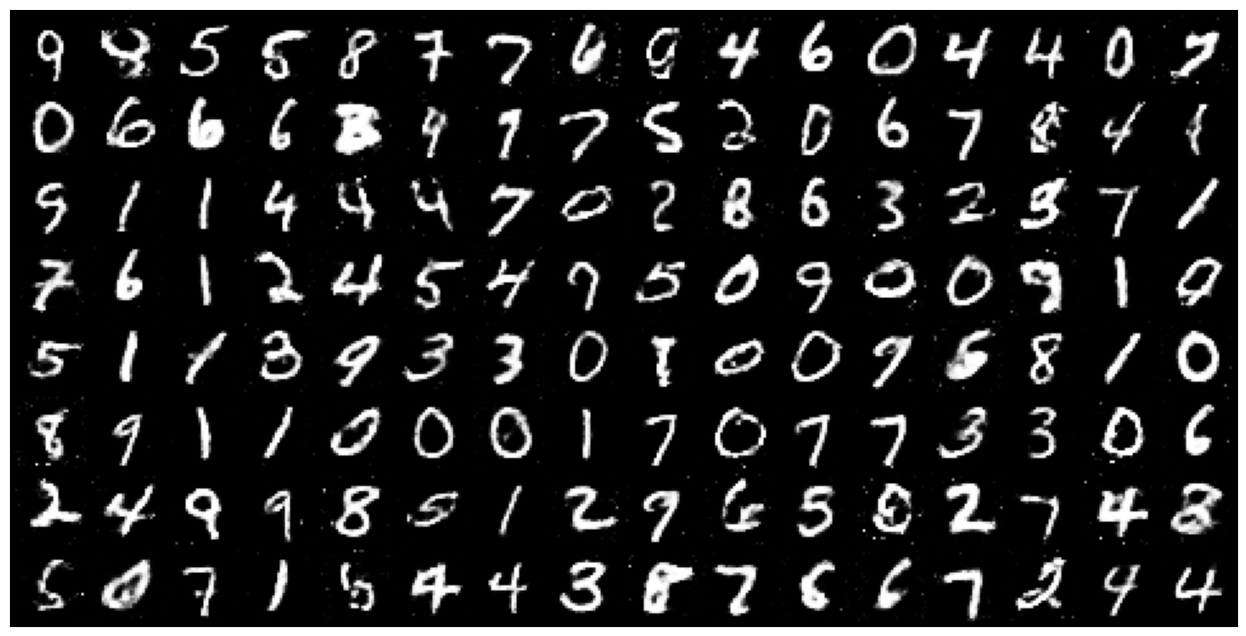

In [26]:
# Plotting a Batch Number of Fake Images Generated from the Input Latent Tensor After the Training

#fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)
print(fake_images.shape)
plot_images(fake_images, batch_size)

In [27]:
# Showing the Saved Images

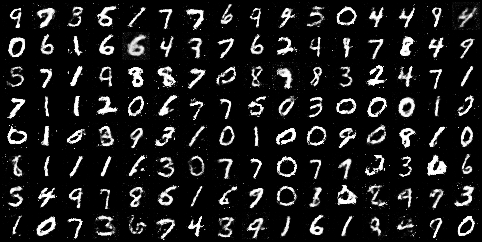

In [28]:
Image('./generated/generated-images-0050.png', height=620)

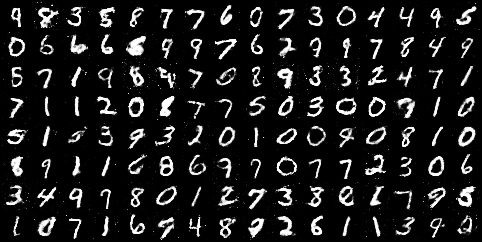

In [29]:
Image('./generated/generated-images-0100.png', height=620)

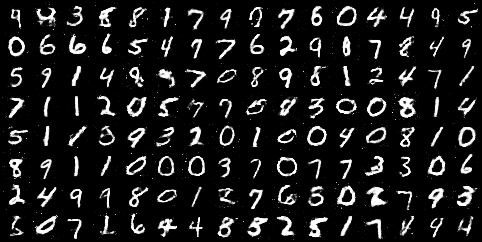

In [30]:
Image('./generated/generated-images-0150.png', height=620)

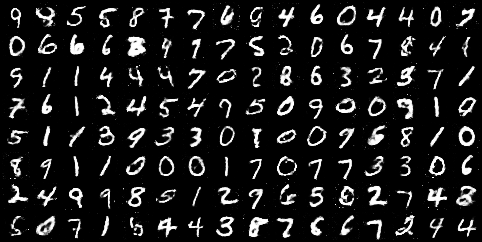

In [31]:
Image('./generated/generated-images-0200.png', height=620)

In [32]:
# Saving a Video of Generated Image Samples Which Shows the Progress of Training the Networks

import cv2
import os

sample_dir = "./generated"
vid_fname = "./gans_training.avi"

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

size = (1240, 620)

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MJPG'),  10, size)
[out.write(cv2.resize(cv2.imread(fname), size)) for fname in files]
out.release()

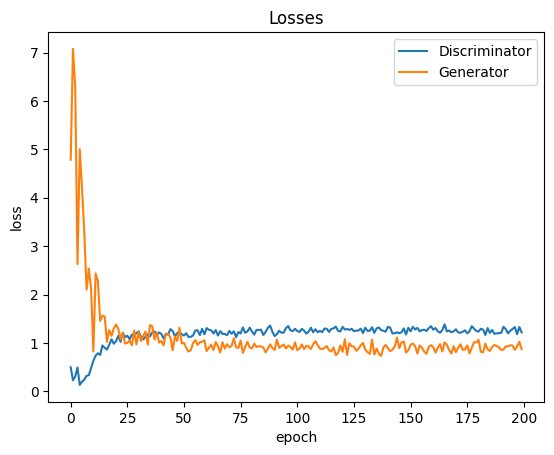

In [33]:
# Plotting the Loss Values per Epoch for Both Generator and Discriminator

plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

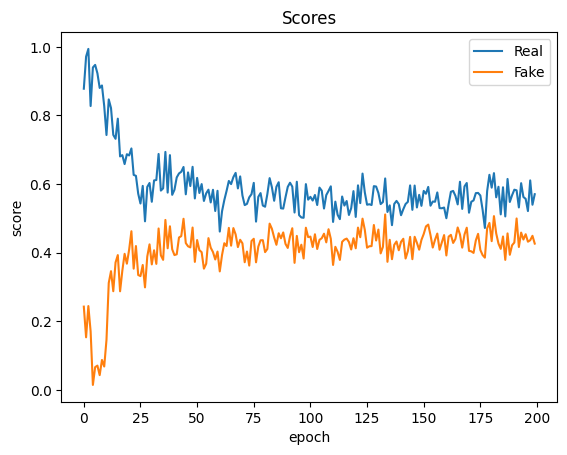

In [34]:
# Plotting Both Real and Fake Scores per Epoch

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

torch.Size([128, 1, 28, 28])


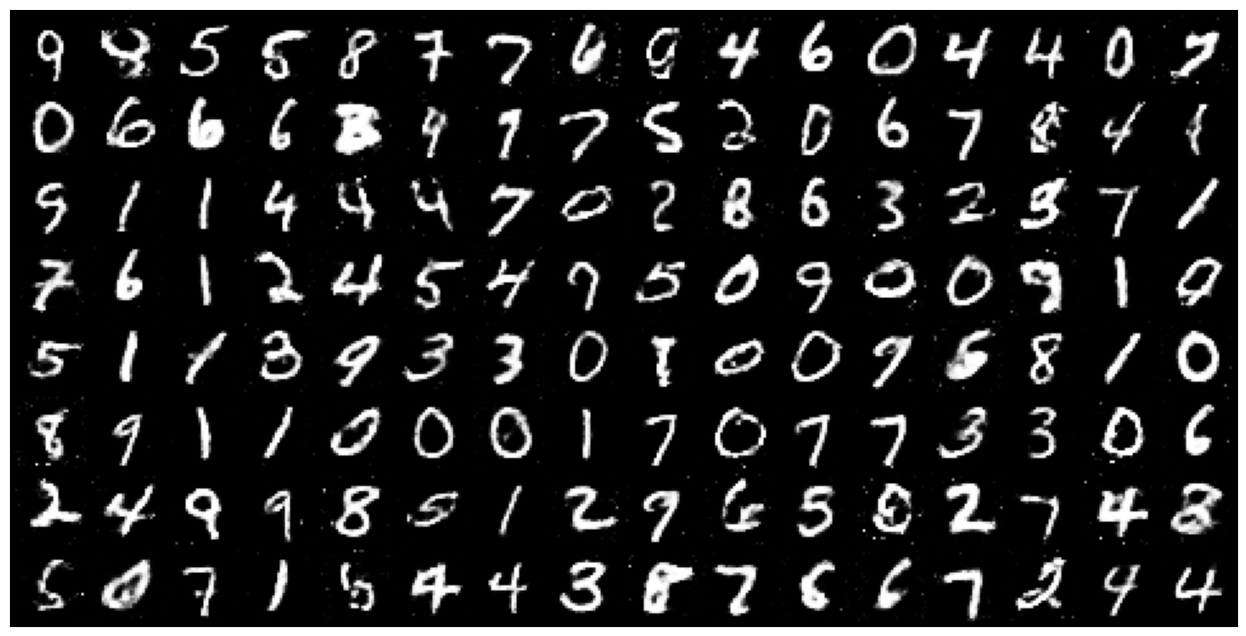

In [35]:
# Definition of a New Generator and a New Discriminator Models to Load the Pre-Saved Model Weights (.pth)

generator_new = Generator(latent_size).to(device)
discriminator_new = Discriminator().to(device)

generator_new.load_state_dict(torch.load('G.pth'))
discriminator_new.load_state_dict(torch.load('D.pth'))

#--------------------------------------------------------

# Plotting a Batch Number of Fake Images Generated by the New Model from the Input Latent Tensor After the Training

#fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)
fake_images_new = generator_new(fixed_latent)

print(fake_images_new.shape)
plot_images(fake_images_new, fake_images_new.size(0))

In [36]:
# Showing That the Discriminator Networks of Both the Two Models Give the Same Prediction Results After Loading the Saved Weights to the New Model

# Printing Only 8 Values to Demonstrate the Identicality
print(f"Discriminator Predictions of the Original Model:\n{discriminator(fake_images)[:8].cpu().detach().numpy()}\n")
print(f"Discriminator Predictions of the New Model:\n{discriminator(fake_images_new)[:8].cpu().detach().numpy()}\n")

Discriminator Predictions of the Original Model:
[[0.4454015 ]
 [0.6002396 ]
 [0.5344693 ]
 [0.30935264]
 [0.5080995 ]
 [0.4743776 ]
 [0.43194497]
 [0.33098692]]

Discriminator Predictions of the New Model:
[[0.4346429 ]
 [0.34541798]
 [0.55207175]
 [0.32013166]
 [0.44279715]
 [0.42503396]
 [0.4983127 ]
 [0.33859453]]



In [37]:
# Zipping the "generated" Folder to Download (Optional)

!zip -r ./generated.zip ./generated &> /dev/null

In [38]:
# Downloading Files (for Colab Runtime)
#   generated.zip
#   gans_training.avi
#   G.pth & D.pth

from google.colab import files as colabfiles

if os.path.isfile("generated.zip"):
    colabfiles.download("generated.zip")
if os.path.isfile("gans_training.avi"):
    colabfiles.download("gans_training.avi")
if os.path.isfile("G.pth"):
    colabfiles.download("G.pth")
if os.path.isfile("D.pth"):
    colabfiles.download("D.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
# Removing the "generated" Folder and the Other Created Files After Downloading (Optional)

if os.path.isdir("generated"):
    shutil.rmtree("generated")
if os.path.isfile("generated.zip"):
    os.remove("generated.zip")
if os.path.isfile("gans_training.avi"):
    os.remove("gans_training.avi")
if os.path.isfile("G.pth"):
    os.remove("G.pth")
if os.path.isfile("D.pth"):
    os.remove("D.pth")

In [40]:
# Removing the "data" Folder and the Downloaded tgz Dataset File (Optional)

if os.path.isdir("data"):
    shutil.rmtree("data")
if os.path.isfile("cifar10.tgz"):
    os.remove("cifar10.tgz")

In [ ]:
# Terminate Session (for Colab Runtime)

from google.colab import runtime

runtime.unassign()